【問題1】ジニ不純度を求める関数

$$
I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}
$$

In [1]:
def calculate_jini(n_total, n1):
    n0 = n_total - n1
    jini = 1 - (np.square(n1/n_total) + np.square(n0/n_total))
    return jini

問題2】情報利得を求める関数

$$
IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)
$$

In [2]:
def get_info_gain(y,n_suitable, ns_1, n_other, no_1):
    # 親ノードのジニ不純度
    n_total_mam = len(y) 
    n1_mam = np.sum(y==1) # 正解ラベルの数
    jini_mam = calculate_jini(len(y), n1_mam)
    
    # 子ノードの加重平均
    if (n_total_mam != n_suitable): # 最低値を除く
        jini_left = calculate_jini(n_suitable, ns_1)
        jini_right = calculate_jini(n_other, no_1)
        weight_ave =  n_suitable/n_total_mam * jini_left + n_other/n_total_mam * jini_right
        
        return jini_mam - weight_ave
    
    else:
        return 0

【問題3】深さ1の決定木分類器クラスの作成

In [3]:
class ScratchDecisionTreeClassifier():
    
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.jini_left = 0
        self.best_feature = 0
        self.best_threshold = 0
        self.label_over = 0
        self.label_under = 0
        self.jini_right = 0
        
    def fit(self, X, y):
        base_score = 0
        for j in range(X.shape[1]):
            for i in range(X.shape[0]):
                # 総当たりで閾値を動かす
                threshold = [X[i,j]]
                suitable_index = np.where(X[:,j]>=threshold)[0] #閾値以上のindex
                n_suitable = len(suitable_index) # 閾値以上の数
                ns_1 = np.sum(y[suitable_index]==1)# 閾値以上のクラス1の数

                other_index = np.where(X[:,j]<threshold)[0] # 閾値未満のindex
                n_other = len(other_index)  # 閾値未満の数
                no_1 = np.sum(y[other_index]==1) # 閾値未満のクラス1の数
                
                info_gain = self.get_info_gain(y, n_suitable, ns_1, n_other, no_1)
                if info_gain > base_score:
                    base_score = info_gain
                    self.best_feature = j
                    self.best_threshold = X[i,j]
                    self.jini_left = self.jini_left
                    self.jini_right =self.jini_right
                    if ns_1 >= n_suitable - ns_1: # 閾値以上のグループのラベルを決定
                        self.label_over = 1
                        self.label_under = 0
                    else:
                        self.label_over = 0
                        self.label_under = 1
    
    def predict(self, X_test):
        X_test = X_test[:,self.best_feature] # 注目する特徴量のみに
        # 閾値以上をlabel_overに置き換える
        y_pred = np.where(X_test>self.best_threshold, self.label_over, self.label_under)
        
        return y_pred
    
    def accuracy(self, X_test, y_test):
        y_pred = self.predict(X_test) # 予測
        accuracy = np.sum(y_pred==y_test)/len(y_test) #等しい
        
        return accuracy
    
    def get_info_gain(self, y, n_suitable, ns_1, n_other, no_1):
        # 親ノードのジニ不純度
        n_total_mam = len(y) 
        n1_mam = np.sum(y==1) # 正解ラベルの数
        jini_mam = self.calculate_jini(len(y), n1_mam)
        
        # 子ノードの加重平均
        if (n_total_mam != n_suitable): # 最低値を除く
            self.jini_left = self.calculate_jini(n_suitable, ns_1)
            self.jini_right = self.calculate_jini(n_other, no_1)
            weight_ave =  n_suitable/n_total_mam * self.jini_left + n_other/n_total_mam * self.jini_right
            
            return jini_mam - weight_ave
        
        else:
            return 0
    
    def calculate_jini(self, n_total, n1):
        n0 = n_total - n1
        jini = 1 - (np.square(n1/n_total) + np.square(n0/n_total))
        
        return jini

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import  train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [5]:
df = pd.read_csv('../ml-scratch/utils/df_simple2.csv')
X = df.iloc[:,1:3].values
y = df.loc[:,'target'].values
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2)

In [6]:
clf = ScratchDecisionTreeClassifier()
clf.fit(X_train,y_train)
print(clf.predict(X_test))
print(clf.accuracy(X_test, y_test))

[0 0 0 1 0 1 0 0]
0.375


【問題6】指標値の算出

In [ ]:
clf.accuracy(X_test, y_test)

In [10]:
def decision_region(X_train, y_train, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['y=1', 'y=0']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は学習用データである。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train : ndarray, shape(n_samples,)
        学習用データの正解値
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

【問題7】決定領域の可視化

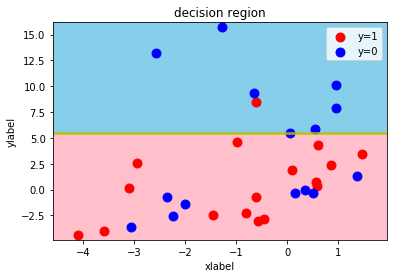

In [11]:
decision_region(X_train,y_train, model=clf)

0.625


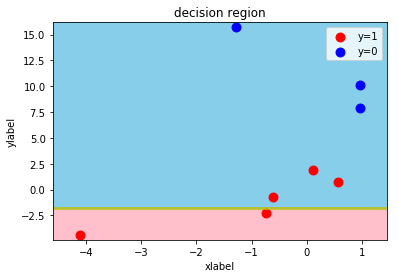

In [12]:
# .pyfileの実行
%run ../ml-scratch/utils/scratch_decision_tree_classifier.py --file_path  "C:/Users/umini/git-test/diveintocode-ml/ml-scratch/utils/df_simple2.csv"

【問題8】決定木の利用場面
決定木のメリットは二つ考えられる

初めに、説明性が高いこと。アルゴリズムは複雑だが、図にしやすく詳しくない人でも納得させやすい

次に、正規分布仮定しなくてよく、どんな分布でも使える点である